<a id='section_id'></a>

<h1> <div align="center"><a> Прогнозирование заказов такси. </a></div> 

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

In [2]:
df = pd.read_csv("/datasets/taxi.csv",  index_col=[0], parse_dates=[0])
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
# данные представлены с 10-минутным интервалом, проведем ресепмлинг по одному часу
df = df.resample('1H').sum()

## Анализ

In [4]:
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [5]:
# проверим, в хронологическом ли порядке расположены даты и время
print(df.index.is_monotonic)
df.describe().T

True


,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


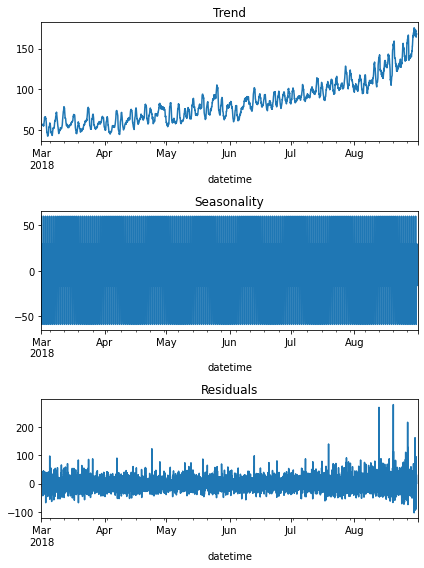

In [6]:
# проанализируем тренды и сезонность
decomposed = seasonal_decompose(df)
plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

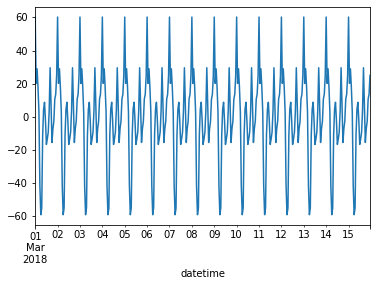

In [7]:
# исследуем сезонность на более коротком интервале 
decomposed.seasonal['2018-03-01':'2018-03-15'].plot()

**Тренд связан со временем года: с конца весны и до конца лета число поездок в аэропорты неуклонно возрастает. Если эти данные анализировать в масштабе нескольких лет, то увеличение поездок в аэропорты летом это уже сезонные изменения.** Сезонность не определена - это просто периодиеские колебания значений. Остатки необъяснимы, это шум.

<AxesSubplot:xlabel='datetime'>

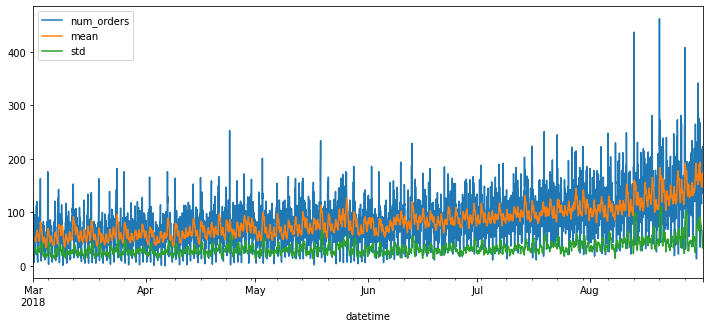

In [8]:
# построим скользящее среднее и стандартное отклонение для нашей выборки
df_r = df.copy(deep=True)
df_r['mean'] = df_r['num_orders'].rolling(15).mean()
df_r['std'] = df_r['num_orders'].rolling(15).std()
df_r.plot(figsize=(12, 5))

   **Наш временной ряд нестационарный, поскольку со временем у него меняется среднее значение и стандартное отклонение. 
                  Вычислим разности временного ряда, чтобы сделать его стационарным.**

<AxesSubplot:xlabel='datetime'>

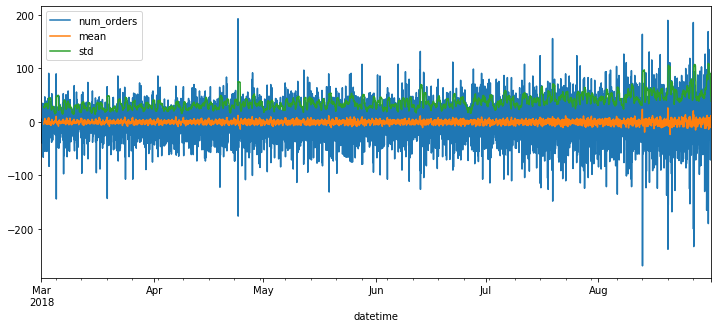

In [9]:
sdf = df.shift()
df_shift = df - sdf
df_shift['mean'] = df_shift['num_orders'].rolling(15).mean()
df_shift['std'] = df_shift['num_orders'].rolling(15).std()
df_shift.plot(figsize=(12, 5))

### Основные выводы анализа исходных данных:
 - после ресемплинга выборка имеет 4416 строк и один столбец с целевым признаком;
 - временной рад представлен данными за период с марта по август 2018 года;
 - данные расположены  в хронологическом порядке;
 - обнаружены возможные выбросы: 0 заказов и 462 заказа за час, но поскольку у нас нет уверенности, что это ошибки сбора данных, оставим их без изменений;
 - выявлен тренд, связанный со временем года: с конца весны и до конца лета число поездок в аэропорты неуклонно возрастает;
 - путем вычисления разности временной ряд стал более стационарным и его можно прогнозировать.

## Обучение
### Создание признаков
Создадим признаки для горизонта прогнозирования в один шаг. Поскольку наша выборка представлена периодом с марта по август 2018 года: имеет смысл выделить признаки month, day, hour и dayoweek. Также выделим предыдущие значения временного ряда и скользящее среднее.

In [10]:
def  make_features(df, max_lag, rolling_mean_size):
    df_f = df.copy(deep=True)
    df_f['month'] = df_f.index.month
    df_f['day'] = df_f.index.day
    df_f['hour'] = df_f.index.hour
    df_f['dayofweek'] = df_f.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_f['lag_{}'.format(lag)] = df_f['num_orders'].shift(lag) 
        
    df_f['rolling_mean'] = df_f['num_orders'].shift(1).rolling(rolling_mean_size).mean()    
    return df_f

In [11]:
# установим количество отстающих значений на уровне 4 
df_f = make_features(df, 4, 4)
df_f.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,86.5


### Разделение выборок

Разобьем данные на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны, поэтому установим их согласно заданию на уровне 10%. **Во избежение утечки целевого признака отключим перемешивание данных с помощью shuffle=False**. Далее объявим переменные с признаками и целевым признаком для каждой из полученных выборок.

In [12]:
train, middle = train_test_split(df_f, shuffle=False, test_size=0.2, random_state=12345)
valid, test = train_test_split(middle, shuffle=False, test_size=0.5, random_state=12345)

train = train.dropna() # удалим пропуски в обучающей выборке для последующего обучения моделей

print(train.index.min(), train.index.max(),"\n",
      valid.index.min(), valid.index.max(),"\n",
      test.index.min(), test.index.max())
print(train.shape, valid.shape, test.shape)

2018-03-01 04:00:00 2018-07-26 03:00:00 
 2018-07-26 04:00:00 2018-08-13 13:00:00 
 2018-08-13 14:00:00 2018-08-31 23:00:00
(3528, 10) (442, 10) (442, 10)


In [13]:
x_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']
x_valid = valid.drop(['num_orders'], axis = 1)
y_valid = valid['num_orders']
x_test = test.drop(['num_orders'], axis = 1)
y_test = test['num_orders']

### Линейная регрессия

In [14]:
%%time
lr = LinearRegression()
lr.fit(x_train, y_train) 
predicted_valid = lr.predict(x_valid)
rmse = mean_squared_error(y_valid, predicted_valid, squared=False)
print("RMSE валидационной выборки:",  "{:,.0f}".format(rmse))

RMSE валидационной выборки: 41
CPU times: user 0 ns, sys: 7.39 ms, total: 7.39 ms
Wall time: 4.7 ms


### Решающее дерево
**Подберем гиперпараметры с помощью GridSearchCV, используя кросс-валидацию для временных рядов TimeSeriesSplit.**

In [15]:
%%time
parametrs = {'max_depth': range (1, 21)}
dtr = DecisionTreeRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits = 5)
grid = GridSearchCV(dtr, parametrs, scoring = 'neg_root_mean_squared_error', cv = tscv)
grid.fit(x_train, y_train) 
grid.best_params_

CPU times: user 1.04 s, sys: 55.1 ms, total: 1.09 s
Wall time: 1.11 s


{'max_depth': 6}

In [16]:
%%time
dtr = DecisionTreeRegressor(random_state=12345, max_depth=6)
dtr.fit(x_train, y_train)
predicted_valid = dtr.predict(x_valid)
rmse = mean_squared_error(y_valid, predicted_valid, squared=False)
print("RMSE валидационной выборки:",  "{:,.0f}".format(rmse))

RMSE валидационной выборки: 37
CPU times: user 12.7 ms, sys: 81 µs, total: 12.7 ms
Wall time: 11.4 ms


### Случайный лес

In [17]:
%%time
parametrs = {'n_estimators': range (10, 21, 1),
            'max_depth': range (11, 21)}
rf = RandomForestRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits = 5)
grid = GridSearchCV(rf, parametrs, scoring = 'neg_root_mean_squared_error', cv = tscv)
grid.fit(x_train, y_train) 
grid.best_params_

CPU times: user 55.5 s, sys: 175 ms, total: 55.7 s
Wall time: 55.7 s


{'max_depth': 13, 'n_estimators': 19}

In [18]:
%%time
rf = RandomForestRegressor(random_state=12345, n_estimators=19, max_depth=13)
rf.fit(x_train, y_train)
predicted_valid = rf.predict(x_valid)
rmse = mean_squared_error(y_valid, predicted_valid, squared=False)
print("RMSE валидационной выборки:",  "{:,.0f}".format(rmse))

RMSE валидационной выборки: 33
CPU times: user 215 ms, sys: 31 µs, total: 215 ms
Wall time: 222 ms


### Градиентный бустинг CatBoost

In [19]:
%%time
cb = CatBoostRegressor(loss_function="RMSE", 
                          iterations=1000, 
                          learning_rate = 0.5, 
                          depth = 4, 
                          verbose=50)

cb.fit(x_train, y_train) 
predicted_valid = cb.predict(x_valid)
rmse = mean_squared_error(y_valid, predicted_valid, squared=False)
print("RMSE валидационной выборки:",  "{:,.0f}".format(rmse))

0:	learn: 29.8519879	total: 47.1ms	remaining: 47.1s
50:	learn: 18.1134853	total: 87.2ms	remaining: 1.62s
100:	learn: 16.0594061	total: 126ms	remaining: 1.12s
150:	learn: 14.5632539	total: 166ms	remaining: 932ms
200:	learn: 13.5231457	total: 204ms	remaining: 811ms
250:	learn: 12.6214879	total: 243ms	remaining: 725ms
300:	learn: 11.7557991	total: 283ms	remaining: 656ms
350:	learn: 11.0884776	total: 324ms	remaining: 599ms
400:	learn: 10.4527154	total: 364ms	remaining: 544ms
450:	learn: 9.8762421	total: 404ms	remaining: 492ms
500:	learn: 9.3057080	total: 442ms	remaining: 441ms
550:	learn: 8.8394293	total: 481ms	remaining: 392ms
600:	learn: 8.4658162	total: 521ms	remaining: 346ms
650:	learn: 8.1261732	total: 561ms	remaining: 301ms
700:	learn: 7.8336017	total: 606ms	remaining: 258ms
750:	learn: 7.4981905	total: 645ms	remaining: 214ms
800:	learn: 7.1437180	total: 684ms	remaining: 170ms
850:	learn: 6.8305059	total: 722ms	remaining: 126ms
900:	learn: 6.5374991	total: 760ms	remaining: 83.5ms
950

### Градиентный бустинг LightGBM

In [29]:
%%time

lg = LGBMRegressor(verbose=50)
lg.fit(x_train, y_train)
predicted_valid = lg.predict(x_valid)
rmse = mean_squared_error(y_valid, predicted_valid, squared=False)
print("RMSE валидационной выборки:",  "{:,.0f}".format(rmse))

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.020629
[LightGBM] [Debug] init for col-wise cost 0.009332 seconds, init for row-wise cost 0.096564 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 3528, number of used features: 9
[LightGBM] [Info] Start training from score 74.293651
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] T

### Градиентный бустинг XGBoost

In [21]:
%%time

xgb = XGBRegressor(verbosity  = 2)
xgb.fit(x_train, y_train)
predicted_valid = xgb.predict(x_valid)
rmse = mean_squared_error(y_valid, predicted_valid, squared=False)
print("RMSE валидационной выборки:",  "{:,.0f}".format(rmse))

[09:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=6
[09:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[09:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[09:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[09:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[09:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[09:17:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[09:17:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[09:17:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 prun

### Константная модель

In [22]:
%%time
# построим константную модель, которая будет предсказывать одинаковое количество заказов, равное среднему значению по выборке
dr = DummyRegressor(strategy='mean').fit(x_train, y_train) 
predicted_valid = dr.predict(x_valid)
rmse = mean_squared_error(y_valid, predicted_valid, squared=False)
print("RMSE валидационной выборки:",  "{:,.0f}".format(rmse))

RMSE валидационной выборки: 58
CPU times: user 1.26 ms, sys: 13 µs, total: 1.27 ms
Wall time: 972 µs


[В начало](#section_id)

## Тестирование
Построим сводную таблицу с основными характеристиками обученных моделей.

In [30]:
pd.DataFrame({'Модель': ["Линейная регрессия", "Решающее дерево", "Случайный лес", "CatBoost", "LightGBM", "XGBoost", "Константная модель"],
              'MAE': [41, 37, 33, 35, 33, 34, 58]}).T

,0,1,2,3,4,5,6
Модель,Линейная регрессия,Решающее дерево,Случайный лес,CatBoost,LightGBM,XGBoost,Константная модель
MAE,41,37,33,35,33,34,58


Наилучший результат RMSE продемонстрировали модель случайного леса и градиентного бустинга LightGBM (RMSE = 33). Однако по скорости обучения все же лидирует модель случайного леса, поэтому тестировать будем ее.**Перед этим объединим обучающую и валидационную выборку в одну и уже на основании ее будем предсказывать значения для тестовой выборки.**

In [24]:
# объединим обучающую и валидационную выборку 
x_fact = pd.concat([x_train, x_valid]) 
y_fact = pd.concat([y_train, y_valid]) 
print(x_fact.index.min(), train.index.max(),"\n",
      y_fact.index.min(), train.index.max(), "\n",
      x_fact.index.is_monotonic,"\n",
      y_fact.index.is_monotonic)

2018-03-01 04:00:00 2018-07-26 03:00:00 
 2018-03-01 04:00:00 2018-07-26 03:00:00 
 True 
 True


In [25]:
%%time
rf_final = RandomForestRegressor(random_state=12345, n_estimators=80, max_depth=16)
rf_final.fit(x_fact, y_fact)
predicted_valid = rf_final.predict(x_test)
rmse = mean_squared_error(y_test, predicted_valid, squared=False)
print("RMSE валидационной выборки:",  "{:,.0f}".format(rmse))
# mae = mean_absolute_error(y_test, predicted_valid)
# print("MAE тестовой выборки:", "{:,.0f}".format(mae))

RMSE валидационной выборки: 47
CPU times: user 1.08 s, sys: 7.99 ms, total: 1.09 s
Wall time: 1.09 s


**Сравним точность предсказания на тестовой выборке.**

Text(0.5, 1.0, 'predict')

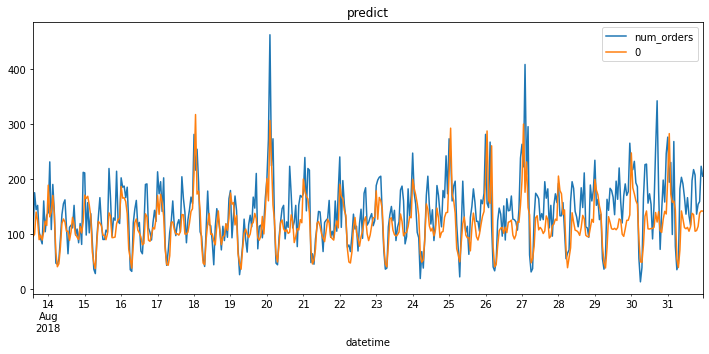

In [26]:
y_predict = pd.DataFrame(predicted_valid).set_index(y_test.index)
pd.DataFrame(y_test).plot(ax=plt.gca(), figsize=(12, 5))
plt.title('fact')
pd.DataFrame(y_predict).plot(ax=plt.gca(), figsize=(12, 5))
plt.title('predict')



На графике можно видеть, что наши предсказания достаточно близки к фактическим. Выведем основные влияющие факторы согласно нашей модели.

,Feature,Value
0,hour,0.299757
1,lag_1,0.284634
2,month,0.106459
3,rolling_mean,0.070807
4,lag_2,0.059593


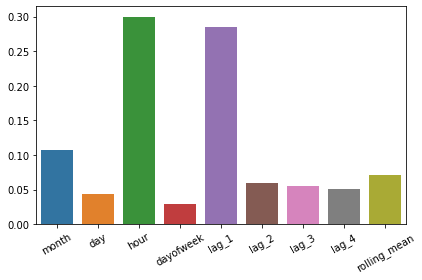

In [27]:
fi = pd.DataFrame({'Feature':x_train.columns,'Value':rf_final.feature_importances_})
display(fi.sort_values('Value',ascending=False).reset_index(drop=True).head())

fi = pd.Series(rf_final.feature_importances_, index=x_train.columns)
sns.barplot(x=x_train.columns, y=rf_final.feature_importances_)
plt.xticks(rotation=30)
plt.tight_layout()

**Основные выводы:**
 * в первую очередь стоит отметить, что все построенные модели продемонстрировали точность в разы лучше, нежели константаная модель, которая количество заказов оценивала средним значением по всей выборке;
 * **наибольшую точность продемонстрировали модель случайного леса и градиентного бустинга LightGBM** (у обеих MAE = 23), чуть хуже модель решающего дерева и градиентного бустинга CatBoost (МАЕ = 26);
 * наибольший вклад в количество заказов вносят признаки hour (в каком часу делается заказ), lag_1 (количество заказов в предыдущем часу) и dayofweek (день недели).